<a href="https://colab.research.google.com/github/anujaprasads/anujashajan/blob/main/Web_Attack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web attack detection using CICIDS2017 dataset

## Data preprocessing


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2023-05-30 10:58:35--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip [following]
--2023-05-30 10:58:35--  https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip [following]
--2023-05-

In [ ]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='cp1252')

<ipython-input-13-d1f0d9ed00c2>:1: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='cp1252')


In [ ]:
df.shape

(458968, 85)

In [ ]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

In [ ]:
df['Label'].unique()

array(['BENIGN', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection', nan], dtype=object)

In [ ]:
df['Label'].value_counts()

BENIGN                        168186
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Web Attack – Sql Injection        21
Name: Label, dtype: int64

In [ ]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

In [ ]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

In [ ]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [ ]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [ ]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [ ]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [ ]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [ ]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

BENIGN                        168186
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Web Attack – Sql Injection        21
Name: Label, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:
 
     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [ ]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [ ]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [ ]:
df_balanced['Label'].value_counts()

BENIGN                        5087
Web Attack – Brute Force      1507
Web Attack – XSS               652
Web Attack – Sql Injection      21
Name: Label, dtype: int64

If necessary, we can keep a single class of attack for experiments.

In [ ]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [ ]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

In [ ]:
df = pd.read_csv('web_attacks_balanced.csv')

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

If necessary, we will work with our own dataset.

In [ ]:
#!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/mix_labelled.zip -O mix_labelled.zip
#!unzip -u mix_labelled.zip

In [ ]:
#df = pd.read_csv('mix_labelled.csv')
#excluded = ['Flow Key', 'Flow Bytes/s', 'Flow MB/s', 'Fwd IAT Min', 
#            'Flow IAT Min', 'Packet Length Mean', 'Average Fwd Segment Size', 'Subflow Fwd Bytes',
#            'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Mean',
#            'Average Bwd Segment Size', 'Bwd Packet Length Mean', 'Packet Length List', 'Total Fwd Packets',
#            'Packet Length Std', 'Packet Length Variance', 'Total Backword Packets', 'Fwd Packet Length Std',
#            'Total Length of Bwd Packets', 'Bwd Header Length']
#df = df.drop(columns=excluded, errors='ignore')

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [ ]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset. 

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

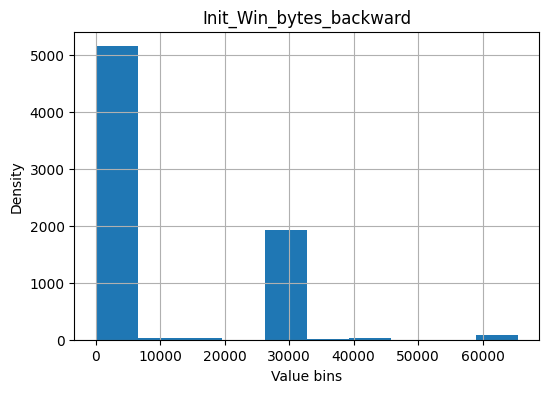

In [ ]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

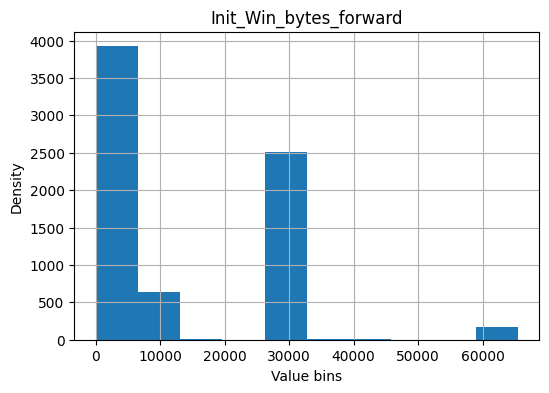

In [ ]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [ ]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2, errors='ignore')

In [ ]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


## Feature importance

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3538, 1: 1548}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)
 
In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.
 
By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.95088409, 0.94891945, 0.96267191, 0.97249509, 0.96660118,
       0.96660118, 0.96062992, 0.9507874 , 0.95669291, 0.94094488])

In [ ]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.33
|   |--- Fwd IAT Std <= 2547638.75
|   |   |--- class: 0
|   |--- Fwd IAT Std >  2547638.75
|   |   |--- Fwd IAT Min <= 15137.50
|   |   |   |--- class: 1
|   |   |--- Fwd IAT Min >  15137.50
|   |   |   |--- class: 0
|--- Packet Length Mean >  0.33
|   |--- Subflow Fwd Bytes <= 32608.50
|   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  32608.50
|   |   |--- class: 1



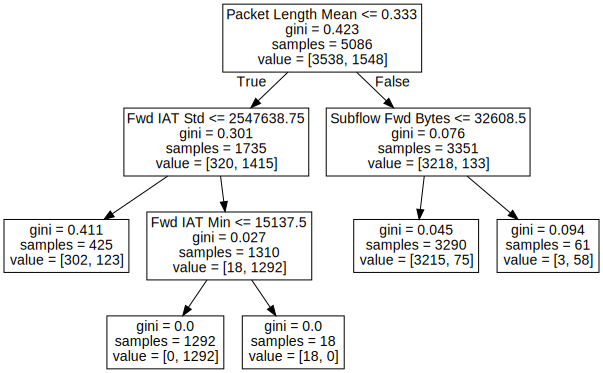

In [ ]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

Analyze the confusion matrix. Which classes are confidently classified by the model?

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1549, 1: 632}

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1548,    1],
       [  84,  548]])

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [ ]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1706177 , 0.        , 0.01943798, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.75346928,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05647504, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [ ]:
sfm.threshold_

0.013513513513513514

In [ ]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [ ]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7534692777660319
1.	Fwd IAT Std - 0.17061769558483741
2.	Subflow Fwd Bytes - 0.05647504310009532
3.	Fwd IAT Min - 0.01943798354903545
4.	Idle Min - 0.0
5.	Bwd IAT Std - 0.0
6.	Fwd IAT Mean - 0.0
7.	Fwd IAT Max - 0.0
8.	Bwd IAT Total - 0.0
9.	Bwd IAT Mean - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [ ]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#13	0.084	Flow Bytes/s
2.	#51	0.082	Average Packet Size
3.	#38	0.066	Max Packet Length
4.	#39	0.063	Packet Length Mean
5.	#7	0.055	Fwd Packet Length Mean
6.	#23	0.053	Fwd IAT Min
7.	#52	0.050	Avg Fwd Segment Size
8.	#61	0.049	Subflow Fwd Bytes
9.	#3	0.041	Total Length of Fwd Packets
10.	#21	0.031	Fwd IAT Std
11.	#15	0.031	Flow IAT Mean
12.	#5	0.030	Fwd Packet Length Max
13.	#0	0.025	Flow Duration
14.	#35	0.022	Fwd Packets/s
15.	#14	0.022	Flow Packets/s
16.	#16	0.021	Flow IAT Std
17.	#33	0.021	Fwd Header Length
18.	#17	0.019	Flow IAT Max
19.	#22	0.018	Fwd IAT Max
20.	#19	0.017	Fwd IAT Total


For comparison, the results of the study [Sharafaldin2018] (compare relatively, without taking into account the multiplier):
 
* Init Win F.Bytes 0.0200
* Subflow F.Bytes 0.0145
* Init Win B.Bytes 0.0129
* Total Len F.Packets 0.0096

And incorrect results [Kostas2018] (error was found in assessing the importance of features, line: *impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})*, the importances[0:20] sample does not take into account that the values are not sorted in descending order):
 
* Flow Bytes/s 0.313402
* Total Length of Fwd Packets 0.304917
* Flow Duration 0.000485
* Fwd Packet Length Max 0.00013

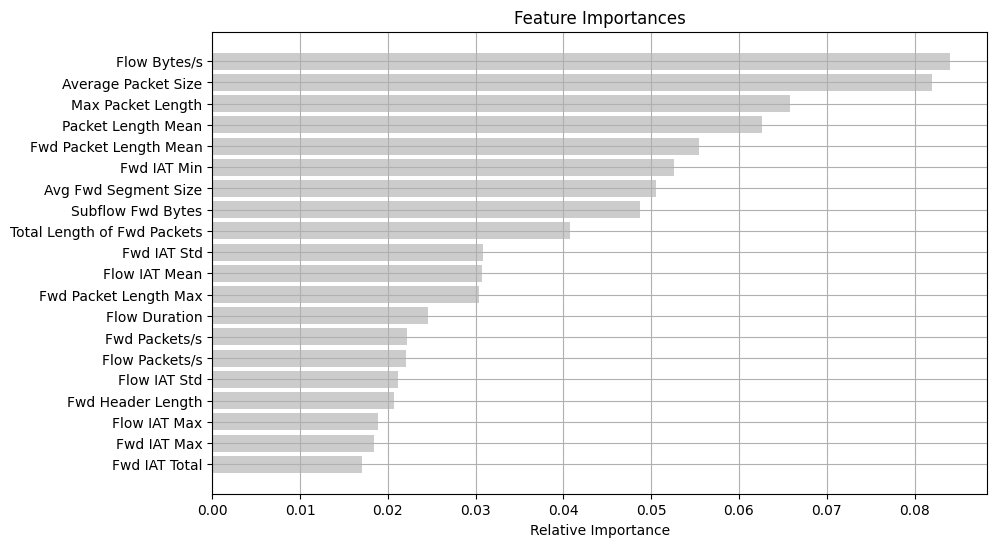

In [ ]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1531,   18],
       [  29,  603]])

Next, for experiments, we keep the first max_features of features with maximum importance.

In [ ]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Avg Fwd Segment Size',
 'Subflow Fwd Bytes',
 'Total Length of Fwd Packets',
 'Fwd IAT Std',
 'Flow IAT Mean',
 'Fwd Packet Length Max',
 'Flow Duration',
 'Fwd Packets/s',
 'Flow Packets/s',
 'Flow IAT Std',
 'Fwd Header Length',
 'Flow IAT Max',
 'Fwd IAT Max',
 'Fwd IAT Total']

## Analysis of selected features

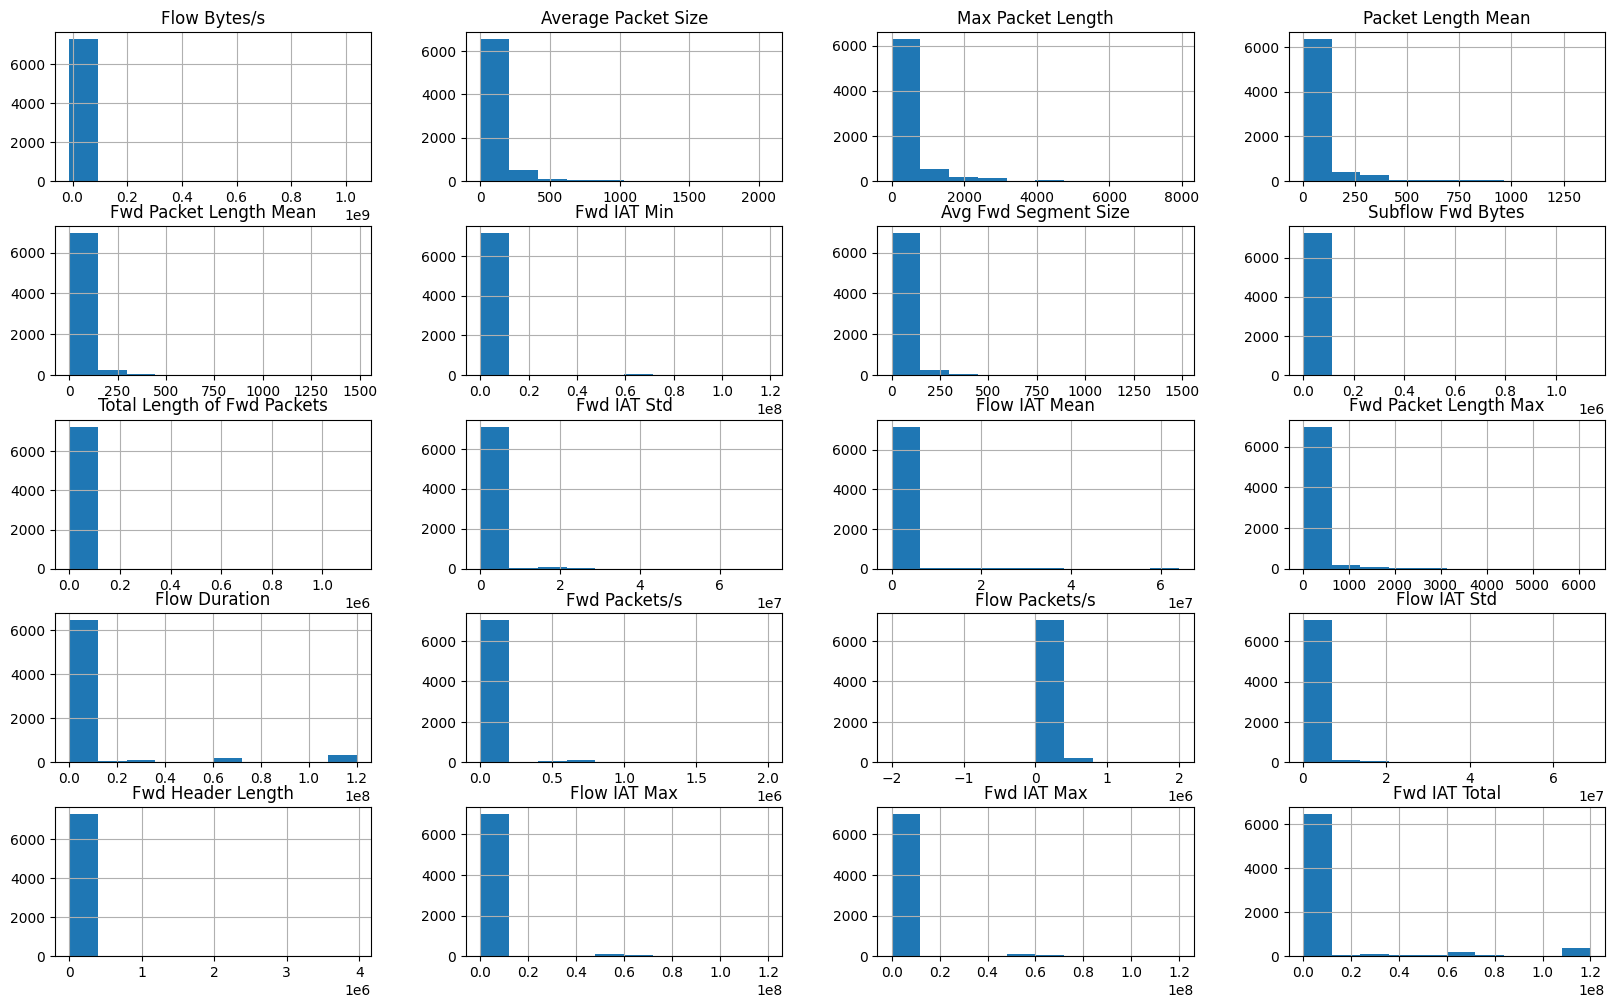

In [ ]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

Install Facets Overview

https://pair-code.github.io/facets/

In [ ]:
!pip install facets-overview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create the feature stats for the datasets and stringify it.

In [ ]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

Display the facets overview visualization for this data.

In [ ]:
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

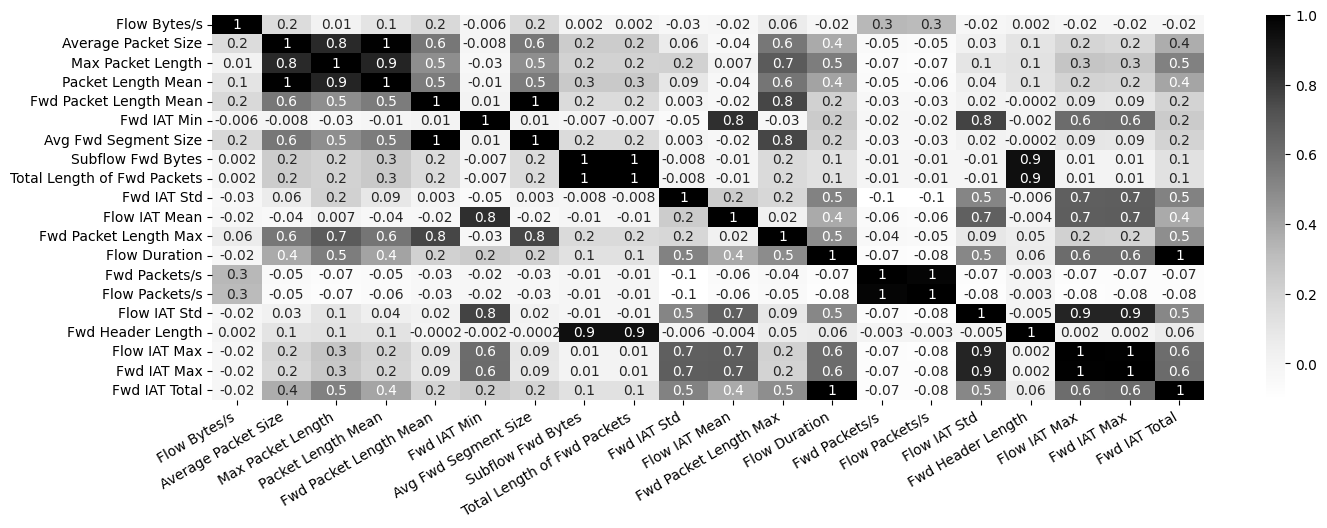

In [ ]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

Remove correlated features.

In [ ]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes', 
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Fwd IAT Std',
 'Flow IAT Mean',
 'Fwd Packet Length Max',
 'Flow Duration']

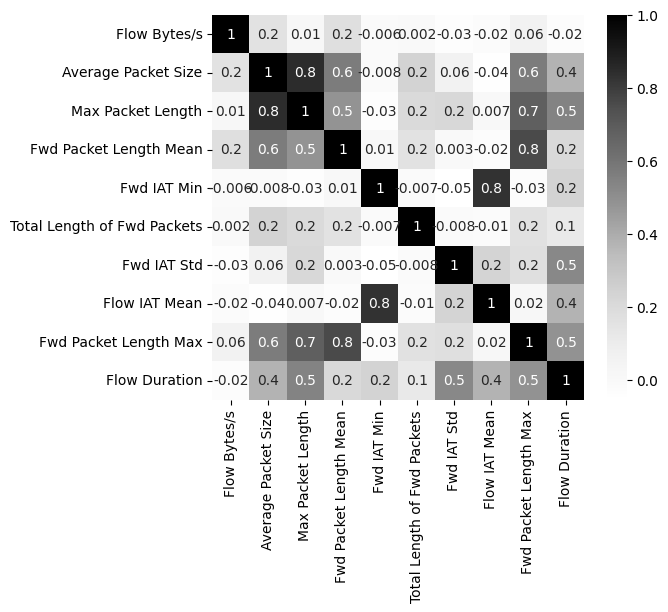

In [ ]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');

## Hyperparameter selection

Reopen the dataset.

In [ ]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


If necessary, we will work with our own dataset.

In [ ]:
#df = pd.read_csv('mix_labelled.csv')
#y = df['Label'].values
#X = df[webattack_features]
#print(X.shape, y.shape)

We get the list of RandomForestClassifier parameters.

In [ ]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [ ]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

CPU times: user 15 s, sys: 32.2 ms, total: 15.1 s
Wall time: 17.3 s


In [ ]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_accuracy,...,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,split7_train_f1,split8_train_f1,split9_train_f1,mean_train_f1,std_train_f1
0,0.034508,0.002436,0.004975,0.000796,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.911967,...,0.864150,0.862359,0.861045,0.861531,0.857211,0.858245,0.855839,0.865686,0.861055,0.002945
1,0.062685,0.006550,0.007269,0.000527,2,3,3,10,"{'max_depth': 2, 'max_features': 3, 'min_sampl...",0.933975,...,0.899178,0.897914,0.898217,0.898821,0.898686,0.911111,0.912737,0.922456,0.908019,0.010045
2,0.076572,0.002263,0.007264,0.000639,3,3,3,10,"{'max_depth': 3, 'max_features': 3, 'min_sampl...",0.935351,...,0.927818,0.926869,0.927159,0.926697,0.927568,0.919302,0.919553,0.928204,0.926013,0.003448
3,0.083613,0.002235,0.007080,0.000253,4,3,3,10,"{'max_depth': 4, 'max_features': 3, 'min_sampl...",0.951857,...,0.949706,0.940891,0.948835,0.940605,0.942603,0.955663,0.935178,0.962312,0.946859,0.007950
4,0.090216,0.003800,0.007178,0.000501,5,3,3,10,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.964237,...,0.961887,0.961678,0.959498,0.960355,0.961180,0.957360,0.956806,0.965089,0.960642,0.002411


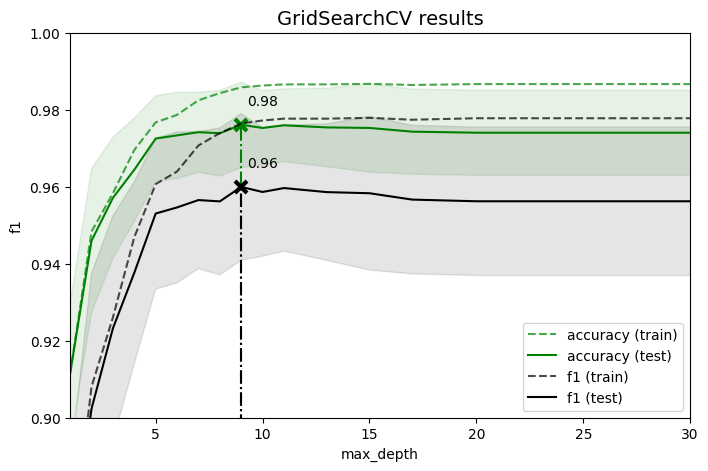

In [ ]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(1, 30)
ax.set_ylim(0.9, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

### Grid search

In [ ]:
parameters = {'n_estimators': [30, 50, 70], 
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10], 
              'max_depth': [10, 17, 23]}

# parameters = {'n_estimators': [250]}

The operation may take a long time, 3-5 minutes depending on the computer performance.

In [ ]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=3, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

CPU times: user 2min 30s, sys: 264 ms, total: 2min 31s
Wall time: 2min 32s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 17, 23],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [3, 5, 7],
                         'n_estimators': [30, 50, 70]},
             refit='f1', return_train_score=True, scoring={'accuracy', 'f1'})

Let's take a look at the results of the parameter selection.

In [ ]:
gcv.best_estimator_ 

RandomForestClassifier(max_depth=17, max_features=7, min_samples_leaf=3,
                       n_estimators=30, random_state=1)

In [ ]:
gcv.best_params_

{'max_depth': 17, 'max_features': 7, 'min_samples_leaf': 3, 'n_estimators': 30}

In [ ]:
gcv.best_score_

0.9558800654988081

## Final model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5086, 10) (5086,)
(2181, 10) (2181,)


In [ ]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [ ]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
    
for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#1	0.318	Average Packet Size
2.	#2	0.299	Max Packet Length
3.	#6	0.150	Fwd IAT Std
4.	#5	0.066	Total Length of Fwd Packets
5.	#0	0.054	Flow Bytes/s
6.	#9	0.035	Flow Duration
7.	#7	0.031	Flow IAT Mean
8.	#4	0.027	Fwd IAT Min
9.	#3	0.016	Fwd Packet Length Mean
10.	#8	0.003	Fwd Packet Length Max


In [ ]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1529,   20],
       [  31,  601]])

In [ ]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9766162310866575
Precision = 0.9677938808373591
Recall = 0.9509493670886076
F1 = 0.9592976855546688


## Model saving

In [ ]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## Model approbation

Open the previously saved model.

In [ ]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

Reopen the dataset.

In [ ]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(7267, 10) (7267,)


If necessary, we will work with our own dataset.

In [ ]:
#df = pd.read_csv('mix_labelled.csv')
#y_test = df['Label'].values
#X_test = df[webattack_features]
#print(X_test.shape, y_test.shape)

In [ ]:
X_test.head()

,Flow Bytes/s,Average Packet Size,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Fwd IAT Std,Flow IAT Mean,Fwd Packet Length Max,Flow Duration
0,1.734043e+06,94.25,112.0,51.0,187.0,102.0,0.0,62.666667,51.0,188.0
1,3.635433e+03,80.75,103.0,39.0,3.0,78.0,0.0,26040.000000,39.0,78120.0
2,1.366337e+06,80.00,94.0,44.0,48.0,88.0,0.0,67.333333,44.0,202.0
3,1.568182e+06,80.00,94.0,44.0,3.0,88.0,0.0,58.666667,44.0,176.0
4,1.194805e+06,80.00,94.0,44.0,1.0,88.0,0.0,77.000000,44.0,231.0


In [ ]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.03826546669006348 seconds
Benign records detected (0), attacks detected (1):


{0: 5090, 1: 2177}

Confusion matrix:

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

In [ ]:
confusion_matrix(y_test, y_pred)

array([[5028,   59],
       [  62, 2118]])

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9833493876427687
Precision = 0.9728984841525035
Recall = 0.9715596330275229
F1 = 0.9722285976589397


Manual calculation of the confusion matrix:
    
    array([[5075,   12],
           [   1, 2179]], dtype=int64)
  
      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

    Точность
    Precision = TP / (TP + FP) = 2179 / (2179 + 12) = 0.9945230488361478

    Полнота
    Recall = TP / (TP + FN) = 2179 / (2179 + 1) = 0.9995412844036697

    F-мера, параметр = 1, гармоническое среднее точности и полноты, множитель = 2
    F1 = 2 * (precision * recall) / (precision + recall) = 0.9970258522077328

    Доля правильных ответов
    Accuracy = TP + TN / (TP + TN + FP + FN) = (2179 + 5075) / 7267 = 0.998211091234347

In [ ]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [ ]:
result[result['Predict'] == 1]

,Flow Bytes/s,Average Packet Size,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Fwd IAT Std,Flow IAT Mean,Fwd Packet Length Max,Flow Duration,Label,Predict
141,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,71.000000,0.0,71.0,0,1
199,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,77.000000,0.0,77.0,0,1
253,4678893.959,1261.669844,7300.0,5.968156,0.0,1135758.0,12391.74733,269.651206,1460.0,119999910.0,0,1
301,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,34.000000,0.0,34.0,0,1
313,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,46.000000,0.0,46.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6793,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,42.000000,0.0,42.0,0,1
6794,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,80.000000,0.0,80.0,0,1
6925,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,103.000000,0.0,103.0,0,1
6991,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00000,43.000000,0.0,43.0,0,1


In [ ]:
result[410:430]

,Flow Bytes/s,Average Packet Size,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Fwd IAT Std,Flow IAT Mean,Fwd Packet Length Max,Flow Duration,Label,Predict
410,4.551212e+02,199.916667,1066.0,138.428571,323.0,969.0,2.003103e+06,4.791930e+05,561.0,5271123.0,1,0
411,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,5.800000e+01,0.0,58.0,0,0
412,1.061947e+05,9.000000,6.0,6.000000,113.0,12.0,0.000000e+00,1.130000e+02,6.0,113.0,0,0
413,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,2.400000e+01,0.0,24.0,0,0
414,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,2.030000e+02,0.0,203.0,0,0
415,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,9.000000e+00,0.0,9.0,0,0
416,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,3.600000e+01,0.0,36.0,0,0
417,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.000000e+00,2.100000e+01,0.0,21.0,0,0
418,4.786244e+02,218.454545,1066.0,139.000000,18.0,973.0,2.021330e+06,5.020638e+05,565.0,5020638.0,1,0
419,4.390897e+05,95.000000,112.0,52.000000,4.0,104.0,0.000000e+00,2.490000e+02,52.0,747.0,0,0
